In [3]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from backtest import Strategy, Portfolio

In [4]:
import pandas_datareader
import pandas_datareader.data as web

In [31]:
class MovingAverageClassStrategy(Strategy):
    
    def __init__(self, symbol, bars, short_window=100, long_window=400):
        self.symbol = symbol
        self.bars = bars
        self.short_window = short_window
        self.long_window = long_window
    
    
    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = 0.0
        signals['short_mavg'] = self.bars['Close'].rolling(self.short_window, min_periods=1).mean()
        signals['long_mavg'] = self.bars['Close'].rolling(self.long_window, min_periods=1).mean() 
        signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:]>signals['long_mavg'][self.short_window:], 1.0, 0.0)
        
        signals['positions'] = signals['signal'].diff()
        
#         print(signals)
        return signals

In [37]:
class MarketOnClosePortfolio(Portfolio):
    def __init__(self, symbol, bars, signals, initial_captial = 100000.00):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_captial = initial_captial
        self.positions = self.generate_positions()
        
        
    def generate_positions(self):
        positions = pd.DataFrame(index=signals.index).fillna(0.0)
        positions[self.symbol] = 100*signals['signal']
        return positions
    
    def backtest_portfolio(self):
        portfolio = self.positions.mul(self.bars['Close'], axis=0)
        pos_diff = self.positions.diff()
        
        portfolio['holdings'] = self.positions.mul(self.bars['Close']).sum(axis=1)
        portfolio['cash'] = self.initial_captial - (pos_diff.mul(self.bars['Close'], axis=0)).sum(axis=1).cumsum()
        
        portfolio['total'] = portfolio['holdings'] + portfolio['cash']
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

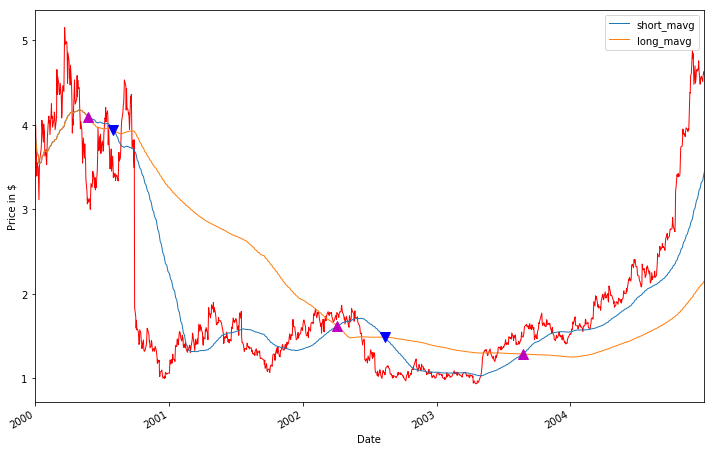

In [45]:
if __name__ == '__main__':
    symbol = 'AAPL'
    #  Start Date for fetching the stock data
    start = datetime.datetime(2000,1,1)

    #  End Date for fetching the stock data
    end = datetime.datetime(2005,1,1)
    aapl = web.DataReader(symbol, 'yahoo', start, end)
    bars = aapl
#     print(aapl)
    mac = MovingAverageClassStrategy(symbol, aapl)
    signals = mac.generate_signals()
    
    portfolio = MarketOnClosePortfolio(symbol, aapl, signals)
    returns = portfolio.backtest_portfolio()
    
    
    # Initialize the plot figure
    fig = plt.figure(figsize=(12,8))

    # Add a subplot and label for y-axis
    ax1 = fig.add_subplot(111,  ylabel='Price in $')

    # Plot the closing price
    aapl['Close'].plot(ax=ax1, color='r', lw=1.)

    # # Plot the short and long moving averages
    signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=1.)

    # Plot the buy signals
    ax1.plot(signals.loc[signals.positions == 1.0].index, 
             signals.short_mavg[signals.positions == 1.0],
             '^', markersize=10, color='m')

    # Plot the sell signals
    ax1.plot(signals.loc[signals.positions == -1.0].index, 
             signals.short_mavg[signals.positions == -1.0],
             'v', markersize=10, color='b')

    # Show the plot
    plt.show()
    